In [53]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [54]:
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [55]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layers_filters = [32, 64]

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layers_filters:
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               activation = 'relu',
               strides = 2,
               padding = 'same')(x)

In [56]:
shape = k.int_shape(x)

In [57]:
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


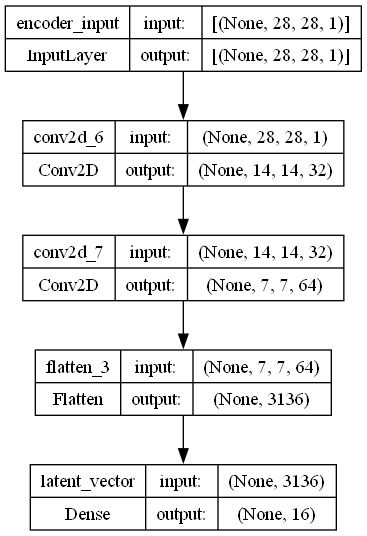

In [58]:
encoder = Model(inputs,
                latent,
                name = 'encoder')
encoder.summary()
plot_model(encoder,
           to_file = 'encoder.png',
           show_shapes = True)

In [59]:
latent_inputs = Input(shape =(latent_dim,), name = 'decoder')

In [60]:
x = Dense(shape[1] *shape[2]* shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [61]:
for filters in layers_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        activation = 'relu',
                        strides = 2,
                        padding = 'same')(x)

In [62]:
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decoder_output',
                          )(x)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

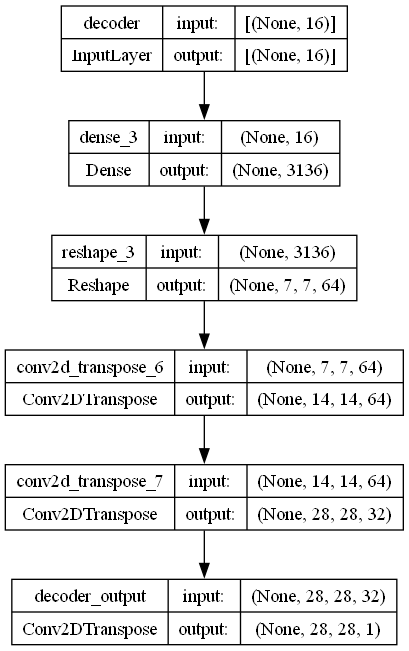

In [63]:
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()
plot_model(decoder, to_file = 'decoder.png', show_shapes = True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


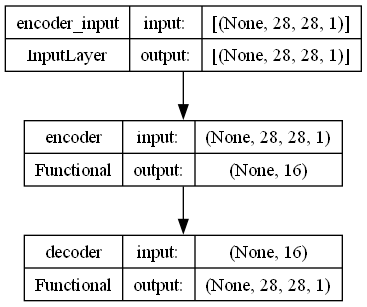

In [64]:
autoencoder = Model(inputs, 
                    decoder(encoder (inputs)),
                    name = 'autoencoder')
autoencoder.summary()
plot_model(autoencoder, 
           to_file = 'autoencoder.png',
           show_shapes = True)

In [65]:
autoencoder.compile(loss = 'mse', optimizer='adam')

In [66]:
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)

1875/1875 [==============================] - 31s 15ms/step - loss: 0.0217 - val_loss: 0.0109


In [72]:
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 4s 12ms/step


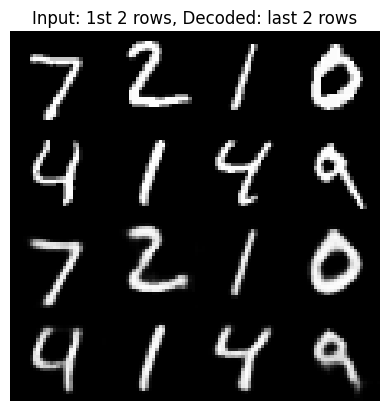

: 

In [ ]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap = 'gray')
plt.savefig('input_and_decoded.png')
plt.show()